<a href="https://colab.research.google.com/github/evanrjiang/NGG6050/blob/main/Jiang_Biomial_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PennNGG/Quantitative-Neuroscience/blob/master/Probability%20Distributions/Python/Binomial.ipynb)

# Definition

The binomial distribution is a discrete probability distribution that describes the probability of obtaining exactly k successes out of n Bernoulli trials, which are individual binary outcomes that each have a success probability of p. For example, if you flip a coin 10 times, what is the probability that it will come up heads 0, 1, 2, ... 10 times?

Mathematically, this distribution defines the probability of obtaining *k* successes in *n* trials given a constant probability of success *p* on each trial, which is defined as:

[1] $P(X=k\: successes)=\left ( \frac{n}{k} \right )p^{k}\left ( 1-p \right )^{n-k}$

for *k* = 0, 1, 2, ... , *n*, and where

$\left ( \frac{n}{k} \right )=\frac{n!}{k!\left ( n-k \right )!}$

 is called the "binomial coefficient" and is pronounced "[n-choose-k](https://www.hackmath.net/en/calculator/n-choose-k)"

# Getting Started with Code


Matlab code is found in the [NGG Statistics GitHub Repository](https://github.com/PennNGG/Statistics.git) under "Probability Distributions/Binomial.m".

Python code is included below. First run the code cell just below to make sure all of the required Python modules are loaded, then you can run the other cell(s).

In [1]:
import numpy as np
import random as rnd
import collections
import matplotlib.pyplot as plt
import time
import scipy.stats as st

from scipy.stats import bernoulli, binom, poisson, chi2
from IPython.display import clear_output
from operator import itemgetter
from statsmodels.stats import proportion

from numpy import matlib

# Neuroscience Example: Quantal Release

From: Johnson, E.W., and Wernig, A. (1971). [The binomial nature of transmitter release at the crayfish neuromuscular junction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1331610/). J Physiol 218, 757-767.

Classic studies by [Bernard Katz and colleagues](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2151334/) indicated that chemical neurotransmitters are released from presynaptic nerve terminals in discrete quanta, or packets, with a relatively constant release probability. A straightforward implication of this idea is that the release statistics (i.e., the distribution of the number of quanta that are actually released in response to a given event like an action potential reaching the presynaptic nerve terminal) should follow a binomial distribution. As stated by Johnson and Wernig:

"If the average probability of release is constant, then it follows from the hypothesis that the relative frequency of 0, 1, 2, 3, . . . quantal releases in a series of trials is given by the successive terms in the binomial expansion $(p + q)^n$, where *q*=1–*p* is the average probability that a quantum will not be released. In a given trial, the probability that *x* quanta will be released (*px*) is given by the binomial term" [i.e., Eq. 1, above, but substitute *x* for *k*].

In other words, if there are *n* available quanta in a presynaptic terminal, and each is released with probability *p*, then the number of quanta that are actually released should follow a binomial distribution with parameters *n* and *p*.

Answers to the exercises below will be found [here](https://github.com/PennNGG/Quantitative-Neuroscience/tree/master/Answers%20to%20Exercises/Python) after the due date.

## Exercise 1
Assume that there are 10 quanta available in a nerve terminal, and for a given release event each is released with a probability of 0.2. For one such event, what is the probability that 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, or 10 quanta will be released?

Probability of 0 quanta release: 0.107292
Probability of 1 quanta release: 0.268217
Probability of 2 quanta release: 0.302409
Probability of 3 quanta release: 0.200915
Probability of 4 quanta release: 0.088344
Probability of 5 quanta release: 0.026427
Probability of 6 quanta release: 0.005537
Probability of 7 quanta release: 0.000778
Probability of 8 quanta release: 7.7e-05
Probability of 9 quanta release: 4e-06


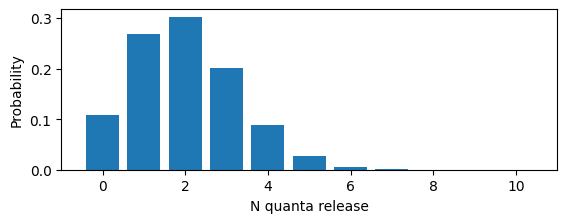

In [2]:
p = 0.2
quanta = 10
num_experiments = 1000000

quanta_release = binom.rvs(quanta,p,size=num_experiments)


# Show a normalized version that is a pdf. Here counts (the x-axis of the histogram)
#   is a DISCRETE variable, so we just have to add up the values
counts = collections.Counter(quanta_release)
normalized_counts = {k: v / total for total in (sum(counts.values()),) for k, v in counts.items()}
for key in sorted(normalized_counts):
  print(f'Probability of {key} quanta release: ' + str(normalized_counts[key]))
plt.subplot(212)
plt.bar(normalized_counts.keys(), normalized_counts.values())
plt.xlim([-1, quanta+1])
plt.xlabel('N quanta release')
plt.ylabel('Probability')
plt.subplots_adjust(hspace=0.3)

## Exercise 2
Let's say you know that a given nerve terminal contains exactly 14 quanta available for release. You have read in the literature that the release probability of these quanta is low, say 0.1. To assess whether this value is reasonable, you run a simple experiment: activate the nerve and measure the number of quanta that are released. The result is 8 quanta. What is the probability that you would get this result (8 quanta) if the true probability of release really was 0.1? What about if the true release probability was much higher; say, 0.7? What about for each decile of release probability (0.1, 0.2, ... 1.0)? Which value of release probability did you determine to be the most probable, given your measurement?

Note: here you are computing a likelihood function: a function describing how the value of the conditional probability *p*(*data* | *parameters*) changes when you hold your data fixed to the value(s) you measured and vary the value(s) of the parameter(s) of, in this case, the binomial distribution. Because you are varying the parameters and not the data, the values of the function are not expected to sum to one (e.g., you can have numerous parameters that have a very high probability of producing the given data) and thus this function is not a probability distribution (see [here](https://www.psychologicalscience.org/observer/bayes-for-beginners-probability-and-likelihood) for an extended discussion). The maximum value of this function is called the maximum likelihood.

In [5]:
def likelihood_binomial(p, n, data):
    # p: probability of success
    # n: number of trials (same for all data points)
    # data: array of observed successes (k values)

    likelihood = np.prod([binom.pmf(k, n, p) for k in data])
    return likelihood

In [6]:
quanta = 14
obs_release = 8
likelihood = {}

for p in np.arange(0.1,1.1,0.1):
  likelihood[p] = likelihood_binomial(p,quanta,[obs_release])

max_likelihood = max(likelihood, key=likelihood.get)
max_probability = likelihood[max_likelihood]
print(f"Most probable release probability: {max_likelihood}, Maximum value: {max_probability}")

  #quanta_release = binom.rvs(quanta, p, size = num_experiments)
  #counts = collections.Counter(quanta_release)
  #normalized_counts = {k: v / total for total in (sum(counts.values()),) for k, v in counts.items()}
  #if obs_release in normalized_counts:
  #  print(f'Probability of obs_release quanta released is ' + str(normalized_counts[obs_release]))
  #else:
  #  print(f'Probability of {obs_release} quanta release is 0')


Most probable release probability: 0.6, Maximum value: 0.20659760529407983


## Exercise 3

Not feeling convinced by your single experiment (good scientist!), you repeat it under identical conditions. This time you measure 5 quanta that were released. Your sample size has now doubled, to two measurements. You now want to take into account both measurements when you assess the likelihoods of different possible values of the underlying release probability. To do so, assume that the two measurements in this sample are independent of one another; that is, the value of each result had no bearing on the other. In this case, the total likelihood is simply the product of the likelihoods associated with each separate measurement. It is also typical to compute the logarithm of each likelihood and take their sum, which is often more convenient. What are the values of the total likelihood and total log-likelihood in this example, if we assume that the true release probability is 0.1?

Of course, knowing those values of the likelihood and log-likelihood is not particularly useful until you can compare them to the values computed for other possible values for the release probability, so you can determine which value of release probability is most likely, given the data. Therefore, compute the full likelihood and log-likelihood functions using deciles of release probability between 0 and 1. What is the maximum value? Can you improve your estimate by computing the functions at a higher resolution? How does the estimate improve as you increase the sample size?

In [7]:
def log_likelihood_binomial(p, n, data):
    # p: probability of success
    # n: number of trials (same for all data points)
    # data: array of observed successes (k values)

    log_likelihood = np.sum([binom.logpmf(k, n, p) for k in data])
    return log_likelihood

In [8]:
quanta = 14
p= 0.1
obs_release = [8,5]
#If the two observed releases are 8 and 5
total_likelihood = likelihood_binomial(p,quanta,obs_release)
log_total_likelihood = log_likelihood_binomial(p,quanta,obs_release)
print(f'Total likelihood is {total_likelihood}')
print(f'Total log-likelihood is {log_total_likelihood}')


total_likelihood = {}
for p in np.arange(0,1.1,0.1):
  total_likelihood[p] = likelihood_binomial(p,quanta,obs_release)

max_total_likelihood = max(total_likelihood, key=total_likelihood.get)
max_total_probability = total_likelihood[max_total_likelihood]
print(f"Most probable release probability: {max_total_likelihood}, Maximum value: {max_total_probability}")

Total likelihood is 1.2378187214998254e-07
Total log-likelihood is -15.904744915931484
Most probable release probability: 0.5, Maximum value: 0.022396467626094804


## Exercise 4

You keep going and conduct 100 separate experiments and end up with these results:

Measured releases	| Count
---------------- | -------
0 | 0
1 | 0
2 | 3
3 | 7
4 | 10
5 | 19
6 | 26
7 | 16
8 | 16
9 | 5
10 | 5
11 | 0
12 | 0
13 | 0
14 | 0

What is the most likely value of *p* (which we typically refer to as $\hat{p}$, which is pronounced as "p-hat" and represents the maximum-likelihood estimate of a parameter in the population given our sample with a resolution of 0.01?

BONUS: Use a fitting procedure to find $\hat{p}$.

Most probable release probability: 0.44


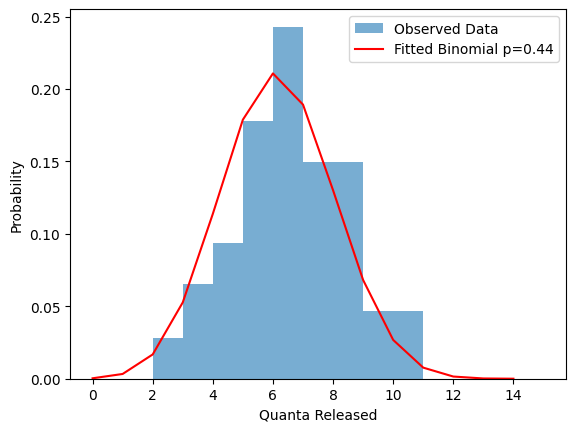

In [9]:
obs_released = np.array([2]*3+[3]*7+[4]*10+[5]*19+[6]*26+[7]*16+[8]*16+[9]*5+[10]*5)
quanta = 14

likelihood = {}
for p in np.arange(0,1.01,0.01):
  likelihood[p] = log_likelihood_binomial(p,quanta,obs_released)

max_likelihood = max(likelihood, key=likelihood.get)
print(f"Most probable release probability: {max_likelihood}")

# Plot histogram of the observed data
plt.hist(obs_released, bins=range(0, quanta+2), density=True, alpha=0.6, label="Observed Data")

# Plot fitted binomial distribution
x = np.arange(0, quanta+1)
plt.plot(x, binom.pmf(x, quanta, max_likelihood), 'r-', label=f'Fitted Binomial p={max_likelihood:.2f}')
plt.xlabel("Quanta Released")
plt.ylabel("Probability")
plt.legend()
plt.show()

## Exercise 5

Let's say that you have run an exhaustive set of experiments on this synapse and have determined that the true release probability is 0.3 (within some very small tolerance). Now you want to test whether changing the temperature of the preparation affects the release probability. So you change the temperature, perform the experiment, and measure 7 quantal events for the same 14 available quanta. Compute $\hat{p}$. Standard statistical inference now asks the question, what is the probability that you would have obtained that measurement given a Null Hypothesis of no effect? In this case, no effect corresponds to an unchanged value of the true release probability (i.e., its value remained at 0.3 even with the temperature change). What is the probability that you would have gotten that measurement if your Null Hypothesis were true? Can you conclude that temperature had an effect?

In [12]:
quanta = 14
obs_released = [7]

likelihood = {}
for p in np.arange(0,1.01,0.01):
  likelihood[p] = log_likelihood_binomial(p,quanta,obs_released)

max_likelihood = max(likelihood, key=likelihood.get)
print(f"Most probable release probability: {max_likelihood}")

Most probable release probability: 0.5


In [13]:
quanta = 14
true_p = 0.3
obs_released = 7
probability = binom.pmf(obs_released,quanta,true_p)
print(f'Probability of obtaining {obs_released} quanta if true release probability is {true_p}: {probability}')

Probability of obtaining 7 quanta if true release probability is 0.3: 0.06181335872712


Here we have a p value of 0.06, which is greater than the standard cutoff of p < 0.05, suggesting that changing the temperature however many degrees it was changedlikely did not have an effect on the release probability of quanta.

## Bonus Exercise

These data are reproduced from Tables 1 and 2 of Johnson and Wernig. Note that *nx* indicates the number of trials ("release events") with *x* measured events. Each row is a separate experiment (don't worry about the ordering, which here is reproduced as it is in the paper).

Temp (°C)	| n0	| n1	| n2	| n3	| n4	| n5+
--- | --| --- | --- | --- | --- | ---
4.0	| 615	| 206	| 33	| 2	| 0	| 0
3.5	| 604	| 339	| 94	| 11	| 2	| 0
0.0 | 	332	| 126	| 21	| 1	| 0	| 0
2.0	| 573	| 443	| 154	| 28	| 2	| 0
6.5	| 172	| 176	| 89	| 12	| 1	| 0
3.0	| 80	| 224	| 200	| 32	| 4	| 0

You can probably already see that some experiments resulted in primarily zero or one events per trial (e.g., the top experiment), whereas others tended to have more events (e.g., the bottom experiment).

Do the quantal event numbers follow a binomial distribution? If so, then that would lend support to the idea that the events are generated by a process that can be characterized in terms of the number of available quanta and the average probability of release of each quantum.

Provide a qualitative answer to this question by comparing the empirical distributions (see the data table, above) to the predicted binomial distribution. To get the predicted distribution (i.e., the probabilities associated with each value of *k* from Eq. 1, given the release probability p and the number of available quanta *n*), you need to determine both *k* and *n* from the empirical measurements. To determine *p*, use Eq. 5 in the paper: $p=1-\frac{\sigma ^{2}}{m}$

where $\sigma ^{2}$ is the variance and *m* is the mean of the trial-by-trial counts that can be determined from the data. To determine *n*, compute *m*/*p* (because *m* = *n* x *p*).

As an added bonus, also include the predicted Poisson distribution, which can be computed using only the mean number of events (*m*, described above).



# Additional Resources

Working with the binomial distribution in [Matlab](https://www.mathworks.com/help/stats/binomial-distribution.html), [R](https://www.rdocumentation.org/packages/stats/versions/3.3/topics/Binomial), and [Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html).

# Credits

Copyright 2021 by Joshua I. Gold, University of Pennsylvania